In [1]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 04:50:01.356985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744692601.574892      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744692601.641037      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip -d glove
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
!gunzip cc.hi.300.vec.gz
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

--2025-04-15 04:50:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.9, 18.239.50.18, 18.239.50.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118942272 (1.0G) [binary/octet-stream]
Saving to: ‘cc.hi.300.vec.gz’

cc.hi.300.vec.gz    100%[===================>]   1.04G   369MB/s    in 2.9s    

2025-04-15 04:50:16 (369 MB/s) - ‘cc.hi.300.vec.gz’ saved [1118942272/1118942272]



In [3]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0 if valid_votes else None

In [7]:
# Load data
hs_train = pd.read_csv("/kaggle/input/hate-speech/hindi_train.csv")
hs_val = pd.read_csv("/kaggle/input/hate-speech/hindi_val.csv")
hs_train["text"] = hs_train["text"].apply(normalize_text)
hs_val["text"] = hs_val["text"].apply(normalize_text)


max_features = 10000
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(hs_train["text"])

X_train = pad_sequences(keras_tokenizer.texts_to_sequences(hs_train["text"]), maxlen=max_len, padding='post')
X_val = pad_sequences(keras_tokenizer.texts_to_sequences(hs_val["text"]), maxlen=max_len, padding='post')
y_train = hs_train["label"].tolist()
y_val = hs_val["label"].tolist()

hurtlex_df = pd.read_csv('/kaggle/input/hurtlex/hurtlex_HI.tsv', sep='\t', engine='python', on_bad_lines='skip')
hurtlex_dict = {}
for _, row in hurtlex_df.iterrows():
    word = str(row['lemma']).strip().lower()
    cat = str(row['category']).strip()
    if word not in hurtlex_dict:
        hurtlex_dict[word] = set()
    hurtlex_dict[word].add(cat)

# HurtLex categories
all_categories = sorted({c for cats in hurtlex_dict.values() for c in cats})
cat2idx = {c: i for i, c in enumerate(all_categories)}
num_cats = len(cat2idx)

def get_hurtlex_vector(text):
    vec = np.zeros(num_cats)
    for token in text.split():
        if token in hurtlex_dict:
            for cat in hurtlex_dict[token]:
                vec[cat2idx[cat]] = 1
    return vec

# Generate features
train_hurtlex = np.array([get_hurtlex_vector(t) for t in hs_train['text']])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in hs_val['text']])

embedding_matrix = np.zeros((max_features, embed_size))
with open('cc.hi.300.vec', encoding='utf8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in keras_tokenizer.word_index and keras_tokenizer.word_index[word] < max_features:
            embedding_matrix[keras_tokenizer.word_index[word]] = np.asarray(values[1:], dtype='float32')

In [8]:
class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, labels, tokenizer, hurtlex_inputs=None, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.hurtlex_inputs = hurtlex_inputs
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': bert_encoded['input_ids'].squeeze(),
            'attention_mask': bert_encoded['attention_mask'].squeeze(),
            'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        if self.hurtlex_inputs is not None:
            item['hurtlex_input'] = torch.tensor(self.hurtlex_inputs[idx], dtype=torch.float)
        return item


In [9]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [ ]:
# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, n_heads=4):
#         super(FusionClassifier, self).__init__()
#         self.bert_encoder = IndicBERTEncoder()
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)
#         self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=n_heads, batch_first=True)
#         self.classifier = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 2)
#         )

#     def forward(self, input_ids, attention_mask, glove_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)        # (B, 128)
#         x2 = self.bilstm_encoder(glove_input)                    # (B, 128)
#         combined = torch.stack([x1, x2], dim=1)                  # (B, 2, 128)
#         attn_output, _ = self.attention(combined, combined, combined)
#         pooled = attn_output.mean(dim=1)                         # (B, 128)
#         return self.classifier(pooled)                           # (B, 2)


In [ ]:
# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, hurtlex_input_dim):
#         super(FusionClassifier, self).__init__()

#         self.bert_encoder = IndicBERTEncoder()                      # x1 (B, 128)
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)       # x2 (B, 128)

#         # HurtLex encoder
#         self.hurtlex_fc = nn.Sequential(
#             nn.Linear(hurtlex_input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 128)                                      # x3 (B, 128)
#         )

#         # Attention over 6 vectors: x1, x2, x3, x1-x2, x1*x2, x1-x3
#         self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

#         # MLP head after attention
#         self.fusion_head = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 2)  # Output logits for binary classification
#         )

#     def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)         # (B, 128)
#         x2 = self.bilstm_encoder(glove_input)                     # (B, 128)
#         x3 = self.hurtlex_fc(hurtlex_input)                       # (B, 128)

#         fusion_seq = torch.stack([x1, x2, x3, x1 - x2, x1 * x2, x1 - x3], dim=1)  # (B, 6, 128)
#         attn_out, _ = self.attn(fusion_seq, fusion_seq, fusion_seq)             # (B, 6, 128)
#         pooled = attn_out.mean(dim=1)                                          # (B, 128)

#         return self.fusion_head(pooled)

In [10]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix, hurtlex_input_dim):
        super(FusionClassifier, self).__init__()

        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        self.hurtlex_fc = nn.Sequential(
            nn.Linear(hurtlex_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128)  # Output size matches x1, x2
        )

        # New output dimension: 512 (x1, x2, x1-x2, x1*x2) + 128 (x3)
        self.fusion_head = nn.Sequential(
            nn.Linear(640, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(glove_input)               # (B, 128)
        x3 = self.hurtlex_fc(hurtlex_input)                 # (B, 128)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2, x3], dim=1)  # (B, 640)
        return self.fusion_head(x)

In [12]:
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

train_hurtlex = np.array([get_hurtlex_vector(t) for t in hs_train['text']])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in hs_val['text']])

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and Dataloaders
train_dataset = FusionDataset(hs_train["text"].tolist(), X_train, y_train, tokenizer, train_hurtlex)
val_dataset = FusionDataset(hs_val["text"].tolist(), X_val, y_val, tokenizer, val_hurtlex)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model, Optimizer, Loss
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training Loop
train_losses, val_losses = [], []
best_f1 = 0.0

for epoch in range(10):
    print(f"\nEpoch {epoch + 1}/10")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            targets += labels.cpu().tolist()

    print("Unique predictions in this epoch:", set(preds))
    print("Unique true labels:", set(targets))

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    f1 = f1_score(targets, preds, average="weighted")
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_hurtlex_hindi_pretrained_hatespeech.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f"✅ Saved best model (F1: {best_f1:.4f})")

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]


Epoch 1/13


Training:   0%|          | 0/1262 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.6189 | Val Loss: 0.4926 | F1: 0.7491 | Precision: 0.7700 | Recall: 0.7542
✅ Saved best model (F1: 0.7491)

Epoch 2/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4902 | Val Loss: 0.4652 | F1: 0.7872 | Precision: 0.7880 | Recall: 0.7872
✅ Saved best model (F1: 0.7872)

Epoch 3/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4718 | Val Loss: 0.4443 | F1: 0.7938 | Precision: 0.7961 | Recall: 0.7938
✅ Saved best model (F1: 0.7938)

Epoch 4/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4658 | Val Loss: 0.4732 | F1: 0.7675 | Precision: 0.7930 | Recall: 0.7707

Epoch 5/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4577 | Val Loss: 0.4411 | F1: 0.7949 | Precision: 0.7992 | Recall: 0.7952
✅ Saved best model (F1: 0.7949)

Epoch 6/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4542 | Val Loss: 0.4333 | F1: 0.8014 | Precision: 0.8023 | Recall: 0.8017
✅ Saved best model (F1: 0.8014)

Epoch 7/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4451 | Val Loss: 0.4472 | F1: 0.7794 | Precision: 0.8004 | Recall: 0.7818

Epoch 8/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4405 | Val Loss: 0.4286 | F1: 0.8051 | Precision: 0.8051 | Recall: 0.8051
✅ Saved best model (F1: 0.8051)

Epoch 9/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4368 | Val Loss: 0.4367 | F1: 0.7894 | Precision: 0.7991 | Recall: 0.7915

Epoch 10/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4318 | Val Loss: 0.4291 | F1: 0.7914 | Precision: 0.7992 | Recall: 0.7931

Epoch 11/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4346 | Val Loss: 0.4186 | F1: 0.8116 | Precision: 0.8117 | Recall: 0.8115
✅ Saved best model (F1: 0.8116)

Epoch 12/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4309 | Val Loss: 0.4465 | F1: 0.7841 | Precision: 0.8062 | Recall: 0.7866

Epoch 13/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.4278 | Val Loss: 0.4287 | F1: 0.8150 | Precision: 0.8153 | Recall: 0.8150
✅ Saved best model (F1: 0.8150)


In [13]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("/kaggle/input/gender-abuse-dataset/train_hi_l1.csv")
annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']

df['label'] = df[annotation_cols].apply(get_majority_label, axis=1)
df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(int)
df['text'] = df['text'].apply(normalize_text)

X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)
y = df['label'].tolist()

train_texts, val_texts, X_train_abuse, X_val_abuse, y_train_abuse, y_val_abuse = train_test_split(
    df["text"].tolist(), X_pad, y, test_size=0.2, random_state=42)



/tmp/ipykernel_31/4058520475.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_hindi_pretrained_hatespeech.pt"))
Epoch 1:

Epoch 1 | F1: 0.6316 | Precision: 0.6192 | Recall: 0.6742
Saved best model (F1: 0.6316)


Epoch 2: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]


Epoch 2 | F1: 0.5720 | Precision: 0.6043 | Recall: 0.5540


Epoch 3: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]


Epoch 3 | F1: 0.5763 | Precision: 0.6281 | Recall: 0.5556


Epoch 4: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]


Epoch 4 | F1: 0.6147 | Precision: 0.6577 | Recall: 0.5968


Epoch 5: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]


Epoch 5 | F1: 0.6045 | Precision: 0.6883 | Recall: 0.5855


Epoch 6: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]


Epoch 6 | F1: 0.6483 | Precision: 0.6788 | Recall: 0.6339
Saved best model (F1: 0.6483)


Epoch 7: 100%|██████████| 310/310 [00:59<00:00,  5.23it/s]
/tmp/ipykernel_31/4058520475.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load

Epoch 7 | F1: 0.6479 | Precision: 0.6915 | Recall: 0.6315



Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.81      0.64      0.71       883
        Hate       0.41      0.62      0.49       357

    accuracy                           0.63      1240
   macro avg       0.61      0.63      0.60      1240
weighted avg       0.69      0.63      0.65      1240



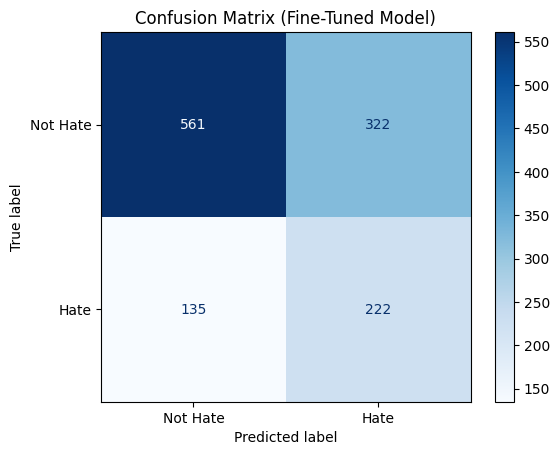

In [18]:
train_hurtlex = np.array([get_hurtlex_vector(t) for t in train_texts])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in val_texts])
train_dataset = FusionDataset(train_texts, X_train_abuse, y_train_abuse, tokenizer, train_hurtlex)
val_dataset = FusionDataset(val_texts, X_val_abuse, y_val_abuse, tokenizer, val_hurtlex)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

label_counts = Counter(y_train_abuse)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = [w / sum(class_weights) for w in class_weights]
class_weights_tensor = torch.tensor(class_weights).to(device)

model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_hurtlex_hindi_pretrained_hatespeech.pt"))

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
# criterion = nn.CrossEntropyLoss()
train_losses, val_losses = [], []
best_f1 = 0.0
for epoch in range(7):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        loss = criterion(model(**inputs), batch["label"].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_preds, val_targets = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            out = model(**inputs)
            val_loss += criterion(out, batch["label"].to(device)).item()
            val_preds += torch.argmax(out, dim=1).cpu().tolist()
            val_targets += batch["label"].tolist()

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(val_targets, val_preds, average='weighted')
    precision = precision_score(val_targets, val_preds, average='weighted')
    recall = recall_score(val_targets, val_preds, average='weighted')
    print(f"Epoch {epoch+1} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_hurtlex_hindi_finetuned_on_abuse.pt")
        print(f"Saved best model (F1: {best_f1:.4f})")

model.load_state_dict(torch.load("fusion_hurtlex_hindi_finetuned_on_abuse.pt"))
model.eval()

final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        final_preds += torch.argmax(outputs, dim=1).cpu().tolist()
        final_targets += labels.cpu().tolist()
print("\nFinal Classification Report:\n")
print(classification_report(val_targets, val_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Fine-Tuned Model)")
plt.show()

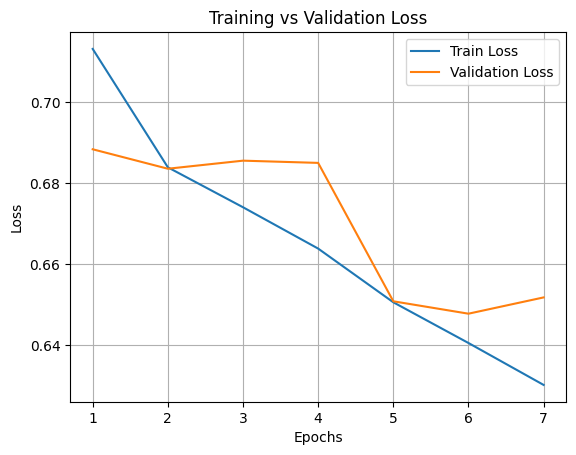

In [19]:
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/4258543137.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_hindi_finetuned_on_abuse.pt"))


Saved predictions to: Task1_output_English.csv

F1-score: 0.6676 | Precision: 0.6921 | Recall: 0.6513

Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.81      0.72      0.76      1158
        Hate       0.33      0.44      0.38       359

    accuracy                           0.65      1517
   macro avg       0.57      0.58      0.57      1517
weighted avg       0.69      0.65      0.67      1517



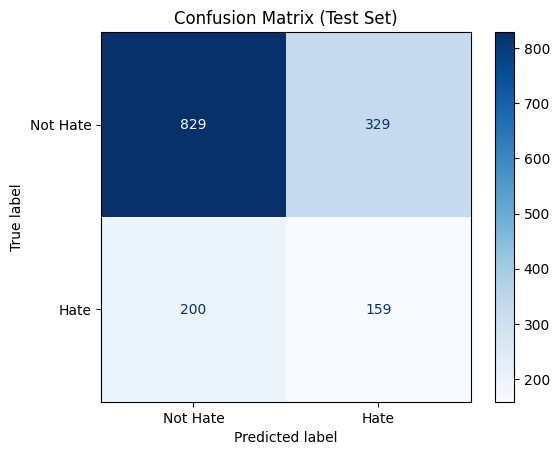

In [21]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess test data
test_df = pd.read_csv("/kaggle/input/gender-abuse-dataset/test_hi_l1.csv",engine='python')
annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
test_df['label'] = test_df[annotation_cols].apply(get_majority_label, axis=1)
test_df = test_df[['text', 'label']].dropna()
test_df['label'] = test_df['label'].astype(int)
test_df['text'] = test_df['text'].apply(normalize_text)

# Tokenize and encode
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_labels = test_df['label'].tolist()
test_hurtlex = np.array([get_hurtlex_vector(text) for text in test_df['text']])
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_labels, tokenizer, hurtlex_inputs=test_hurtlex)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_hurtlex_hindi_finetuned_on_abuse.pt"))
model.eval()

# Run inference
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(labels.cpu().tolist())

output_df = pd.DataFrame({'id': np.arange(1, len(all_preds)+1), 'value': all_preds})
output_df.to_csv('/kaggle/working/Task1_output_English.csv', index=False)
print("Saved predictions to: Task1_output_English.csv")

f1 = f1_score(all_targets, all_preds, average="weighted")
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
print(f"\nF1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()